In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt

/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.interpolate as interpolate
import scipy.optimize as optimize

In [3]:
# Modules for generating waveforms
import lalsimulation # Get waveform functions
import lal # Get constants
import pycbc.types # TimeSeries
import pycbc.waveform # Waveforms

__init__: Setting weave cache to /var/folders/zl/bw0yy2l15g339xpfq2gmxh7c0000gn/T/501_python27_compiled/0f9d09/0f9d091579730f944829c2cd00d5501da9029cae


In [540]:
import imp

import plotparams
imp.reload(plotparams)
from plotparams import *

import waveform
imp.reload(waveform)
from waveform import *

import constants
imp.reload(constants)
from constants import *

<module 'waveform' from 'waveform.pyc'>

In [330]:
MF_ISCO = 1.0/(np.pi*6.0**(3.0/2.0))
X_ISCO = 1.0/6.0
MOMEGA_ISCO = 1.0/6.0**(3.0/2.0)

def f_isco(mtot):
    """ISCO GW frequency.
    mass1, mass2 in units of M_sun.
    f_isco in Hz.
    """
    return MF_ISCO * C_SI**3 / (G_SI * MSUN_SI * mtot)

def mf_to_f(mf, mtot):
    return mf * C_SI**3 / (G_SI * MSUN_SI * mtot)

def f_to_mf(f, mtot):
    return f * (G_SI * MSUN_SI * mtot) / C_SI**3 

In [331]:
MF_ISCO, X_ISCO, MOMEGA_ISCO, f_isco(2.8), mf_to_f(0.001, 2.8), f_to_mf(10, 2.8)

(0.021658244478713225,
 0.16666666666666666,
 0.06804138174397717,
 1570.419532532294,
 72.50908697035804,
 0.00013791374871522012)

In [445]:
# Maximum sampling delta_t to capture ISCO
DTBYM_NYQUIST_MAX = 1.0/(2.0*MF_ISCO)
DTBYM_NYQUIST_MAX

23.085896942913553

# TaylorF2 waveform

In [344]:
def lamtilde_of_eta_lam1_lam2(eta, lam1, lam2):
    """$\tilde\Lambda(\eta, \Lambda_1, \Lambda_2)$.
    Lambda_1 is assumed to correspond to the more massive (primary) star m_1.
    Lambda_2 is for the secondary star m_2.
    """
    return (8.0/13.0)*((1.0+7.0*eta-31.0*eta**2)*(lam1+lam2) + np.sqrt(1.0-4.0*eta)*(1.0+9.0*eta-11.0*eta**2)*(lam1-lam2))

def deltalamtilde_of_eta_lam1_lam2(eta, lam1, lam2):
    """This is the definition found in Les Wade's paper.
    Les has factored out the quantity \sqrt(1-4\eta). It is different from Marc Favata's paper.
    $\delta\tilde\Lambda(\eta, \Lambda_1, \Lambda_2)$.
    Lambda_1 is assumed to correspond to the more massive (primary) star m_1.
    Lambda_2 is for the secondary star m_2.
    """
    return (1.0/2.0)*(
                      np.sqrt(1.0-4.0*eta)*(1.0 - 13272.0*eta/1319.0 + 8944.0*eta**2/1319.0)*(lam1+lam2)
                      + (1.0 - 15910.0*eta/1319.0 + 32850.0*eta**2/1319.0 + 3380.0*eta**3/1319.0)*(lam1-lam2)
                      )

In [350]:
def taylort4_xdot(mfreq, eta):
    """3.5PN point-particle amplitude.
    FFT sign convention is $\tilde h(f) = \int h(t) e^{-2 \pi i f t} dt$
    where $h(t) = h_+(t) + i h_\times(t)$. 
    """
    euler_gamma = 0.5772156649015329
    
    # Calculate the coefficients once
    xdot00 = (64.0*eta)/5.0
    
    xdot10 = -( (743.0 + 924.0*eta)/336.0 )

    xdot15 = 4.0*np.pi

    xdot20 = 34103.0/18144.0 + (13661.0*eta)/2016.0 + (59.0*eta**2)/18.0

    xdot25 = -( 4159.0/672.0 + 15876.0*eta/672.0 )*np.pi

    xdot30 = 16447322263.0/139708800.0 - (1712.0*euler_gamma)/105.0 \
    + (16.0*np.pi**2)/3.0 - (856.0*np.log(16.0))/105.0 \
    - ( 56198689.0/217728.0 - (451.0*np.pi**2/48.0) )*eta \
    + (541.0*eta**2)/896.0 \
    - (5605*eta**3)/2592.0

    xdot30ln = -(856.0/105.0)

    xdot35 = -( 4415.0/4032.0 - (358675.0*eta)/6048.0 - (91495*eta**2)/1512.0 )*np.pi
    
    # Now calculate phase for each freq
    x = (np.pi*mfreq)**(2.0/3.0)

    xdot = xdot00*x**5 * (1.0 + xdot10*x + xdot15*x**1.5 + xdot20*x**2 + xdot25*x**2.5 \
                          + (xdot30+xdot30ln*np.log(x))*x**3 + xdot35*x**3.5)
    return xdot


def taylorf2_amp(mfreq, eta):
    """3.5PN point-particle amplitude.
    FFT sign convention is $\tilde h(f) = \int h(t) e^{-2 \pi i f t} dt$
    where $h(t) = h_+(t) + i h_\times(t)$.
    """
    euler_gamma = 0.5772156649015329
    
    # Calculate the coefficients once
    # !!!!!!! The imaginary parts of the coefficients correspond to
    # using h = h_+ - i h_x (not h_+ + i h_x). This doesn't really 
    # matter since you take the absolute value, but you should really
    # correct it to make things cleaner. !!!!!!!
    a00 = -8.0*np.sqrt(np.pi/5.0)*eta
    
    a10 = -(107.0/42.0) + (55.0*eta)/42.0
    
    a15 = 2.0*np.pi
    
    a20 = -(2173.0/1512.0) - (1069.0*eta)/216.0 + (2047.0*eta**2/1512.0)
    
    a25 = -(107.0*np.pi)/21.0 + ( (34.0*np.pi)/21.0 - 24.0j )*eta
    
    a30 = 27027409.0/646800.0 - (856.0*euler_gamma)/105.0 + (2*np.pi**2)/3.0 \
    - (428.0*np.log(16.0))/105.0 + (428.0j*np.pi)/105.0 \
    + ( -278185.0/33264.0 + (41.0*np.pi**2)/96.0 )*eta \
    - (20261.0*eta**2)/2772.0 \
    + (114635.0*eta**3)/99792.0
    
    a30ln = -428.0/105.0
    
    # Now calculate amplitude for each freq
    # Use TaylorT4 value for xdot
    # A22 has a very small phase component. Ignore it by taking the absolute value.
    x = (np.pi*mfreq)**(2.0/3.0)
    A22 = a00*x*( 1.0 + a10*x + a15*x**1.5 + a20*x**2 + a25*x**2.5 + (a30+a30ln*np.log(x))*x**3 )
    xdot = taylort4_xdot(mfreq, eta)
    A22tilde = np.abs(A22) * np.sqrt( 2.0 * np.pi / (3.0 * x**0.5 * xdot) )
    
    # Convert spherical harmonic coefficient A22 to h
    return 0.5*np.sqrt(5.0/np.pi) * A22tilde


################################################
# !!!You should also add in the tidal terms!!!
################################################
def taylorf2_phase(mfreq, tbymc, phic, eta, lambda1, lambda2):
    """3.5PN point-particle phase.
    FFT sign convention is $\tilde h(f) = \int h(t) e^{-2 \pi i f t} dt$
    where $h(t) = h_+(t) + i h_\times(t)$.
    """
    euler_gamma = 0.5772156649015329
    tlam = lamtilde_of_eta_lam1_lam2(eta, lambda1, lambda2)
    dtlam = deltalamtilde_of_eta_lam1_lam2(eta, lambda1, lambda2)
    # Calculate the coefficients once
    a00 = 3.0/(128.0*eta)
    
    a10 = 3715.0/756.0 + 55.0*eta/9.0
    
    a15 = -16.0*np.pi
    
    a20 = 15293365.0/508032.0 + (27145.0*eta)/504.0 + (3085.0*eta**2)/72.0
    
    a25 = (38645.0/756.0 - 65.0*eta/9)*np.pi
    
    a25ln = (3.0/2.0) * (38645.0/756.0 - (65.0*eta)/9.0)*np.pi
    
    a30 = 11583231236531.0/4694215680.0 - (6848.0*euler_gamma)/21.0 - (640.0*np.pi**2)/3.0 - 6848.0/63.0*np.log(64.0) \
    + (-15737765635.0/3048192.0 + (2255.0*np.pi**2)/12.0)*eta \
    + (76055.0*eta**2)/1728.0 \
    - (127825.0*eta**3)/1296.0
    
    a30ln = -(3.0/2.0) * 6848.0/63.0
    
    a35 = (77096675.0/254016.0 + (378515.0*eta)/1512.0 - (74045.0*eta**2)/756.0)*np.pi
    
    a50t = -39.0*tlam/2.0
    
    a60t = -3115.0*tlam/64.0 + 6595.0*np.sqrt(1.0-4.0*eta)*dtlam/364.0
    
    # Now calculate phase for each freq
    x = (np.pi*mfreq)**(2.0/3.0)
    
    print 
    phi = -2.0*np.pi*mfreq*tbymc + phic + np.pi/4.0 \
    - a00*x**(-5.0/2.0)*(1.0 + a10*x + a15*x**1.5 + a20*x**2.0 \
                         + (a25+a25ln*np.log(x))*x**2.5 \
                         + (a30+a30ln*np.log(x))*x**3.0 \
                         + a35*x**3.5 \
                         + a50t*x**5 + a60t*x**6)
    return phi


def taylorf2(tbymc, phic, eta, lambda1, lambda2, mf_lower, mf_upper, delta_mf):
    """Calculate 3.5PN TaylorF2 waveform in dimensionless units.
    FFT sign convention is $\tilde h(f) = \int h(t) e^{-2 \pi i f t} dt$
    where $h(t) = h_+(t) + i h_\times(t)$.
    """
    mfreq = np.arange(mf_lower, mf_upper, delta_mf)
    amp = taylorf2_amp(mfreq, eta)
    phase = taylorf2_phase(mfreq, tbymc, phic, eta, lambda1, lambda2)
    return Waveform.from_amp_phase(mfreq, amp, phase)

# Functions for Fourier transform and conditioning waveforms

In [8]:
def plot_waveforms(axes, waveforms, xi=-np.inf, xf=np.inf, npoints=1000):
    axes.axhline(0.0, color='k', ls=':')
    
    for h in waveforms:
        xiplot = max(xi, h.x[0])
        xfplot = min(xf, h.x[-1])
        hcomp = h.interpolate_complex()
        times = np.linspace(xiplot, xfplot, npoints)
        hs = hcomp(times)
        
        axes.plot(times, np.real(hs))
        axes.plot(times, np.abs(hs))

In [9]:
def fourier_transform(data, dt):
    """Core part of the Fourier transform.
    """
    npoints = len(data)
    data_tilde = dt*np.fft.fft(data)
    freqs = np.arange(npoints)/(npoints*dt)
    return freqs, data_tilde

In [10]:
def fourier_transform_waveform(h, dt):
    hresamp = h.interpolate_complex()(h.x)
    npoints = len(hresamp)
    freqs, htilde = fourier_transform(hresamp, dt)
    return Waveform.from_complex(freqs, htilde)

In [11]:
def truncate_beginning(h, xstart, remove_start_phase=False):
    """
    """
    ampint = h.interpolate('amp')
    phaseint = h.interpolate('phase')
    istart = np.searchsorted(h.x, xstart)
    if xstart == h.x[istart]:
        xnew = h.x[istart:]
    else:
        xnew = np.concatenate(([xstart], h.x[istart:]))
    return Waveform.from_amp_phase(xnew, ampint(xnew), phaseint(xnew), remove_start_phase=remove_start_phase)

# Make conditioned FD waveforms

In [14]:
def dimensionless_td_waveform(q, lambda1, lambda2, mf_lower, delta_tbym, approximant='TaylorT4'):
    """Wrapper for pycbc waveforms to make them dimensionless.
    Take dimensionless arguments and return dimensionless waveform.
    """
    # dimensionless -> physical:
    # Pick fiducial mtot = 1Msun and distance = 1Mpc
    # pycbc expects units of Msun and Mpc
    mtot = 1.0
    distance = 1.0
    inclination = 0.0
    
    mass1 = mtot / (1.0 + q)
    mass2 = mtot * q / (1.0 + q)
    
    f_lower = C_SI**3 * mf_lower / (G_SI * MSUN_SI * mtot)
    delta_t = G_SI * MSUN_SI * mtot * delta_tbym / C_SI**3
    
    hp, hc = pycbc.waveform.get_td_waveform(approximant=approximant, 
                        mass1=mass1, mass2=mass2, lambda1=lambda1, lambda2=lambda2, 
                        distance=distance, inclination=inclination, 
                        delta_t=delta_t, f_lower=f_lower, f_ref=f_lower)
    
    hphys = Waveform.from_hp_hc(np.array(hp.sample_times), np.array(hp), np.array(hc))
    
    # physical -> dimensionless:
    return physical_to_dimensionless_time(hphys, mtot, distance)

In [446]:
def dimensionless_fd_waveform(q, lambda1, lambda2, mf_lower, delta_mf, approximant='TaylorF2'):
    """Wrapper for pycbc waveforms to make them dimensionless.
    Take dimensionless arguments and return dimensionless waveform.
    """
    # dimensionless -> physical:
    # Pick fiducial mtot = 1Msun and distance = 1Mpc
    # pycbc expects units of Msun and Mpc
    mtot = 1.0
    distance = 1.0
    inclination = 0.0
    
    mass1 = mtot / (1.0 + q)
    mass2 = mtot * q / (1.0 + q)
    
    f_lower = C_SI**3 * mf_lower / (G_SI * MSUN_SI * mtot)
    delta_f = C_SI**3 * delta_mf / (G_SI * MSUN_SI * mtot)
    
    hp, hc = pycbc.waveform.get_fd_waveform(approximant=approximant, 
                        mass1=mass1, mass2=mass2, lambda1=lambda1, lambda2=lambda2, 
                        distance=distance, inclination=inclination, 
                        delta_f=delta_f, f_lower=f_lower, f_ref=f_lower)

    # Combine plus and cross polarizations: ~h(f) = ~h_+(f) + j ~h_x(f)
    hphys = Waveform.from_hp_hc(np.array(hp.sample_frequencies), np.array(hp), np.array(hc))
    
    # physical -> dimensionless:
    return physical_to_dimensionless_freq(hphys, mtot, distance)

In [15]:
def interpolate_time_of_frequency(h, order=3):
    """Generate interpolating function for t(f).
    """
    # Calculate frequency at each data point
    time = h.x
    phaseoft = h.interpolate('phase', order=order)
    omegaoft = phaseoft.derivative(n=1)
    freq = omegaoft(time)/(2*np.pi)
    
    # Find region where frequency is monotonically increasing, then construct t(f)
    i_end_mono = next( (i for i in range(len(freq)-1) if freq[i]>=freq[i+1]), (len(freq)-1) )
    
    # Interpolate the monotonic part
    toffreq = interpolate.UnivariateSpline(freq[:i_end_mono], time[:i_end_mono], k=order, s=0)
    
    return toffreq

In [17]:
def window_waveform_in_frequency_interval(h, fon_end, foff_start, foff_end):
    """Take two waveforms that have already been aligned in time and phase
    and smoothly transition from h1 to h2 over the window [wi, wf].
    """
    
    def winoff(t, wi, wf):
        return 0.5*(1.0 + np.cos( (np.pi*(t-wi))/(wf-wi) ) )
    
    def winon(t, wi, wf):
        return 0.5*(1.0 - np.cos( (np.pi*(t-wi))/(wf-wi) ) )
    
    toff = interpolate_time_of_frequency(h)
    xon_end = float(toff(fon_end))
    xoff_start = float(toff(foff_start))
    xoff_end = float(toff(foff_end))
    
    # searchsorted finds index of (sorted) time where point should be inserted,
    # pushing the later points to the right.
    # indices will be just to the right of the boundaries [wi, wf]:
    ion_end = np.searchsorted(h.x, xon_end)
    ioff_start = np.searchsorted(h.x, xoff_start)
    ioff_end = np.searchsorted(h.x, xoff_end)
    
    # Times (window on, middle, wondow off)
    xson = h.x[:ion_end]
    xsoff = h.x[ioff_start:ioff_end]
    
    hwin = h.copy()
    hwin.amp[:ion_end] *= winon(xson, hwin.x[0], xon_end)
    hwin.amp[ioff_start:ioff_end] *= winoff(xsoff, xoff_start, xoff_end)
    hwin.amp[ioff_end:] *= 0.0
    
    return hwin

In [372]:
def conditioned_waveform(q, lambda1, lambda2, mf_lower, 
                         delta_tbym, length, mfon_end, mfoff_start, mfoff_end, mftrunc_start, 
                         approximant='TaylorT4'):
    """
    """
    # Generate waveform
    h = dimensionless_td_waveform(q, lambda1, lambda2, mf_lower, delta_tbym, approximant=approximant)
    
    # Window the waveform
    h = window_waveform_in_frequency_interval(h, mfon_end, mfoff_start, mfoff_end)
    
    # extend the waveform
    ndata = len(h.x)
    times = h.x[0] + np.arange(0.0, length, delta_tbym)
    ntimes = len(times)
    ampall = np.zeros(ntimes)
    # Make phase continuous even when amplitude goes to zero (for fun)...
    phaseall = np.ones(ntimes)*h.phase[-1]
    ampall[:ndata] = h.amp
    phaseall[:ndata] = h.phase
    hextend = Waveform.from_amp_phase(times, ampall, phaseall)
    
    #fig, axes = plt.subplots(1, figsize=(16, 6))
    #plot_waveforms(axes, [h], xi=-np.inf, xf=np.inf, npoints=1000)
    
    # Fourier transform
    htilde = fourier_transform_waveform(hextend, delta_tbym)
    
    # Truncate waveform
    htrunc = truncate_beginning(htilde, mftrunc_start, remove_start_phase=True)
    
#     # Use the same time shift for all waveforms
#     htrunc.phase -= 2.0*np.pi*htrunc.x*tshift
#     htrunc.add_phase(remove_start_phase=True)
    return htrunc


def fit_time_phase_shift(freq, phase, phase_anal, f_fitend):
    """Fit the difference phase-phase_anal in the interval [freq[0], f_fitend).
    
    """
    # Data to fit a line to
    diff = phase - phase_anal
    i_fitend = np.searchsorted(freq, f_fitend)
    freq_data = freq[:i_fitend]
    diff_data = diff[:i_fitend]
        
    # The linear model
    def line_fit(x, a, b):
        return a + b*x
    
    # Do the least squares fit
    coeffs, covariances = optimize.curve_fit(line_fit, freq_data, diff_data)
    
    shifted_phase = phase - line_fit(freq, *coeffs)
    return shifted_phase


def match_taylorf2_at_beginning(h, q, lambda1, lambda2, f_fitend):
    """
    """
    # Taylor f2 phase
    f2_phase = taylorf2_phase(h.x, 0.0, 0.0, q/(1+q)**2, lambda1, lambda2)
    
    # Calculated the Shifted phase that matches TaylorF2 at the beginning
    shifted_phase = fit_time_phase_shift(h.x, h.phase, f2_phase, f_fitend)

    # Wrap then unwrap phase to correct for insufficient sampling of original waveform h
    comp_data = h.amp*np.exp(1.0j*shifted_phase)
    hnew = Waveform.from_complex(h.x, comp_data)
    
    # Change the start phase to exactly that of TaylorF2
    hnew.add_phase(f2_phase[0]-hnew.phase[0])
    
    return hnew

# Testing waveform preconditioning functions

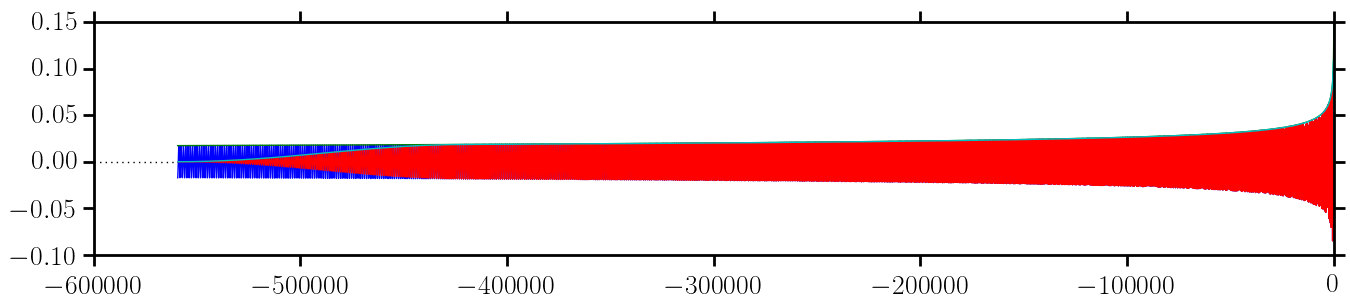

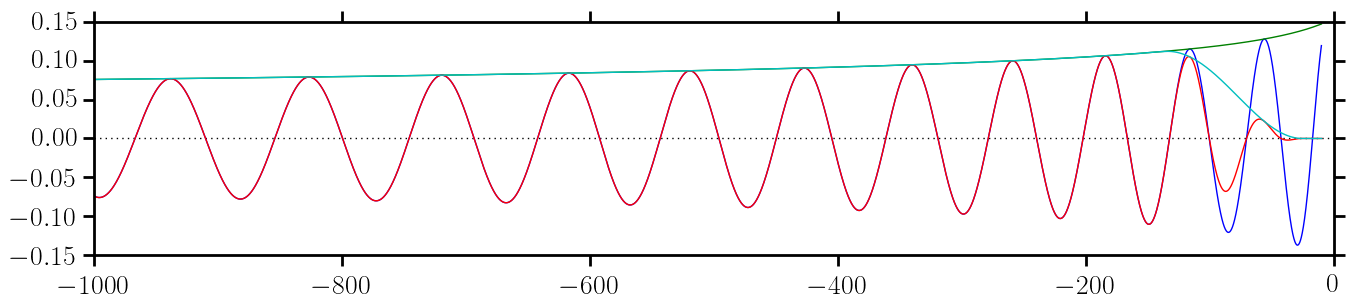

In [112]:
q, lambda1, lambda2 = 0.5, 0, 0
mf_lower, delta_tbym = 0.0009, 10.0
h = dimensionless_td_waveform(q, lambda1, lambda2, mf_lower, delta_tbym, approximant='TaylorT4')
hwin = window_waveform_in_frequency_interval(h, 0.001, 0.015, 0.020)

fig, axes = plt.subplots(1, figsize=(16, 3))
plot_waveforms(axes, [h, hwin], npoints=10000)

fig, axes = plt.subplots(1, figsize=(16, 3))
plot_waveforms(axes, [h, hwin], xi=-1000, npoints=10000)

In [300]:
q, lambda1, lambda2 = 1.0, 500, 500
mf_lower, delta_tbym = 0.0009, 10.0
length = 1.0e6
mfon_end, mfoff_start, mfoff_end = 0.001, 0.015, 0.020
mftrunc_start = mfon_end
f_fitend = 0.002

h = conditioned_waveform(q, lambda1, lambda2, mf_lower, delta_tbym, length, mfon_end, mfoff_start, mfoff_end, mftrunc_start)
h = match_taylorf2_at_beginning(h, q, lambda1, lambda2, f_fitend)

f2_lower = f_to_mf(10, 2.8)
#f2_lower = mftrunc_start
f2_upper = MF_ISCO
hf2 = taylorf2(0, 0, q/(1+q)**2, lambda1, lambda2, f2_lower, f2_upper, 1.0e-5)

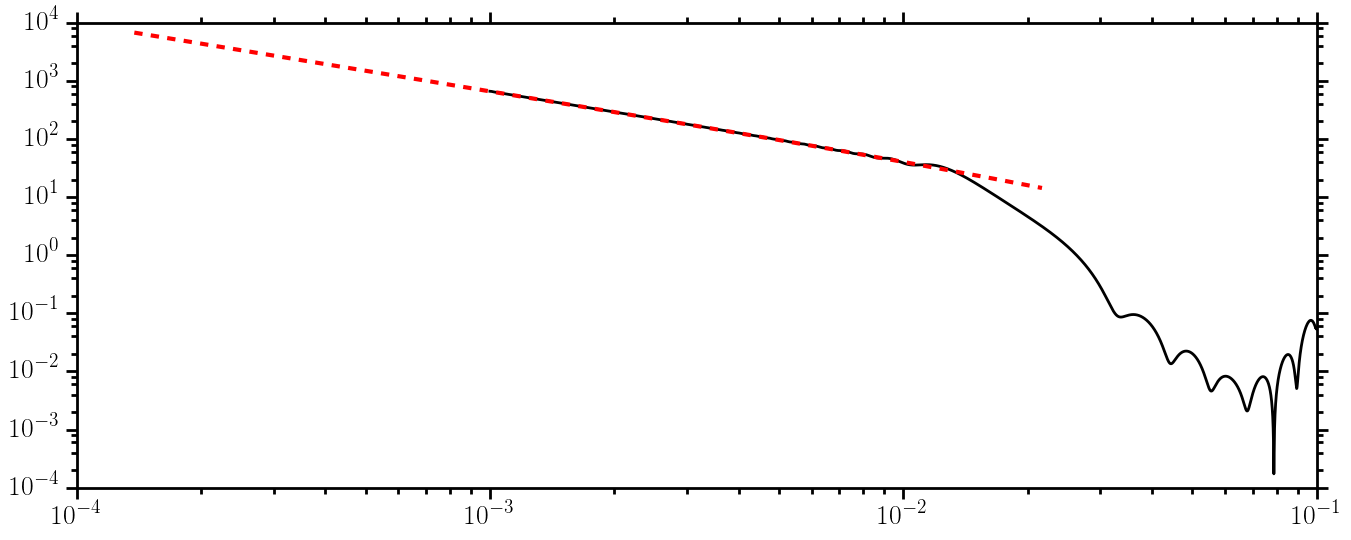

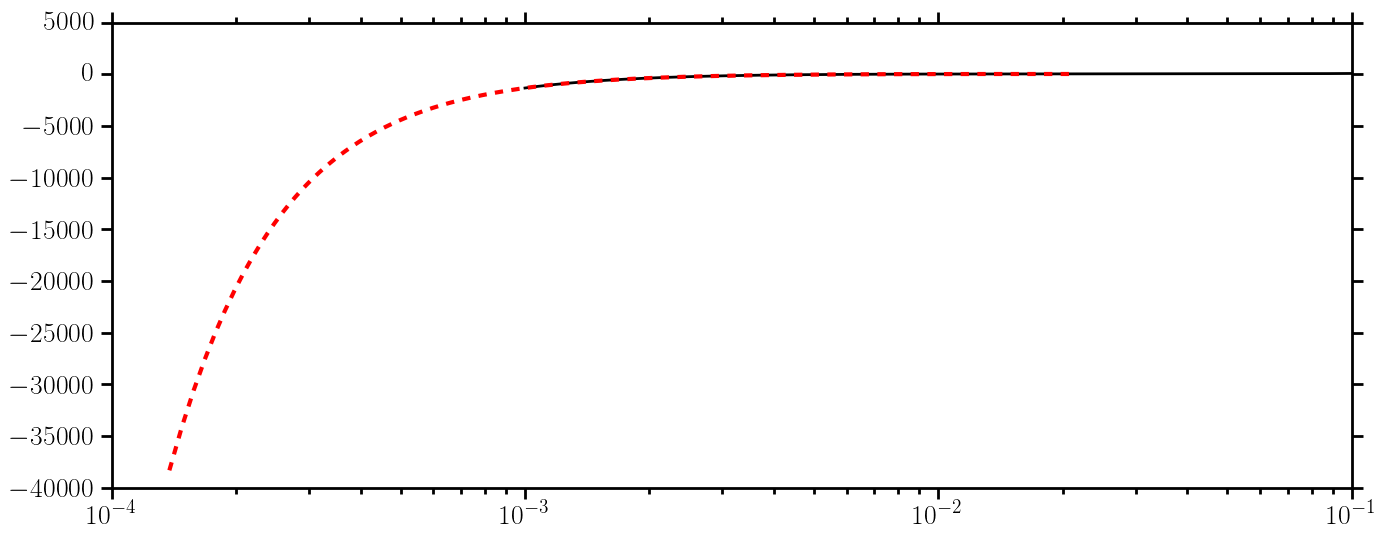

In [301]:
fig, axes = plt.subplots(1, figsize=(16, 6))
axes.plot(h.x, h.amp, c='k', lw=2)
axes.plot(hf2.x, hf2.amp, c='r', lw=3, ls='--')
axes.set_xscale('log')
axes.set_yscale('log')
#axes.set_xlim(100, 5000)

fig, axes = plt.subplots(1, figsize=(16, 6))
axes.plot(h.x, h.phase, c='k', lw=2)
axes.plot(hf2.x, hf2.phase, c='r', lw=3, ls='--')
axes.set_xscale('log')
#axes.set_xlim(100, 5000)
#axes.set_ylim(0, 200)

# diff = subtract_waveform_phase(h1trunc, h2trunc)
# fig, axes = plt.subplots(1, figsize=(16, 6))
# axes.plot(diff.x, diff.phase, c='k', lw=2)
# axes.set_xscale('log')
# axes.set_yscale('symlog', linthreshy=1.0)
# axes.set_xlim(100, 5000)

In [431]:
q, lambda1, lambda2 = 1.0, 500, 500
mf_lower, delta_tbym = 0.0009, 10.0
length = 2.0e6
mfon_end, mfoff_start, mfoff_end = 0.001, 0.015, 0.020
mftrunc_start = mfon_end
f_fitend = 0.002

params = np.linspace(0.5, 1.0, 51)
#params = np.linspace(0, 5000, 51)
hlist = []
for p in params:
    print p,
    h = conditioned_waveform(p, lambda1, lambda2, mf_lower, delta_tbym, 
                             length, mfon_end, mfoff_start, mfoff_end, mftrunc_start)
    h = match_taylorf2_at_beginning(h, p, lambda1, lambda2, f_fitend)
    hlist.append(h)

0.5 0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6 0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8 0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9 0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 1.0


0.021 1522.69082638


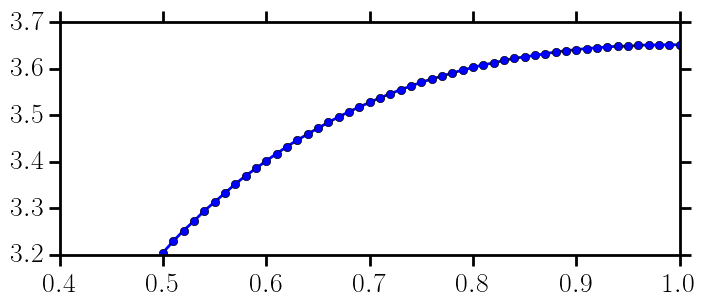

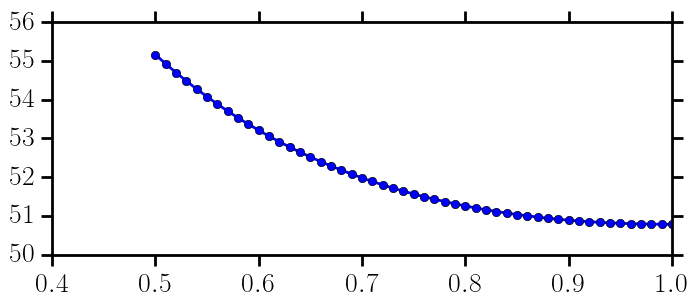

In [432]:
f = 0.021
print f, mf_to_f(f, 2.8)

amps = []
for h in hlist:
    amp = h.interpolate('amp')(f)
    amps.append(amp)
    
fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(params, amps, 'o', ls='-', lw=2)


phis = []
for h in hlist:
    phi = h.interpolate('phase')(f)
    phis.append(phi)
    
fig, axes = plt.subplots(1, figsize=(8, 3))
#axes.plot(params, phis-phis[0], 'o', ls='-', lw=2)
axes.plot(params, phis, 'o', ls='-', lw=2)

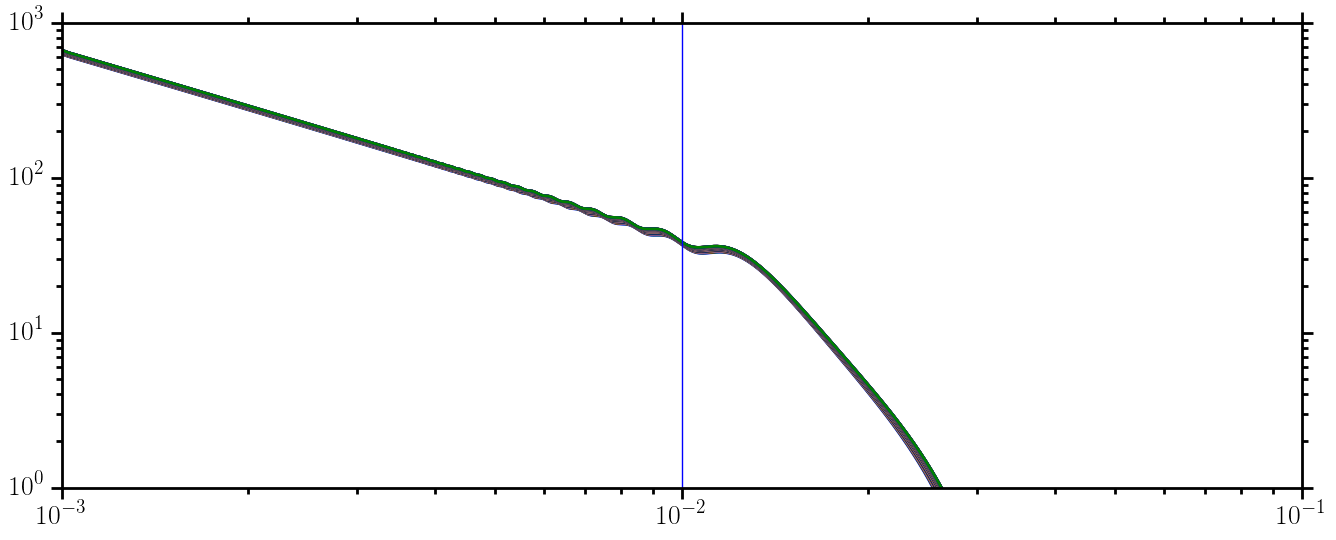

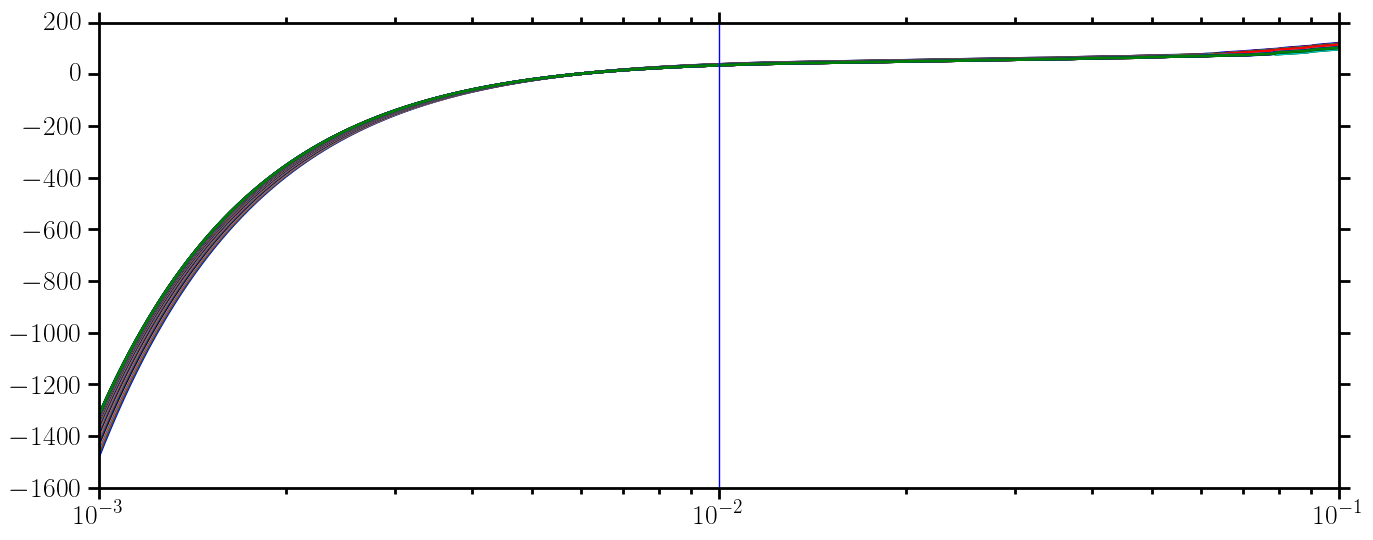

In [441]:
fig, axes = plt.subplots(1, figsize=(16, 6))
for h in hlist:
    axes.plot(h.x, h.amp, lw=2)
axes.axvline(f)
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_ylim(1.0e0, 1.0e3)


fig, axes = plt.subplots(1, figsize=(16, 6))
for h in hlist:
    axes.plot(h.x, h.phase, lw=2)
    #axes.plot(h.x, h.phase-hlist[0].phase, lw=2)
axes.axvline(f)
axes.set_xscale('log')

# Compare with TaylorF2 over parameter space

0.01 725.090869704


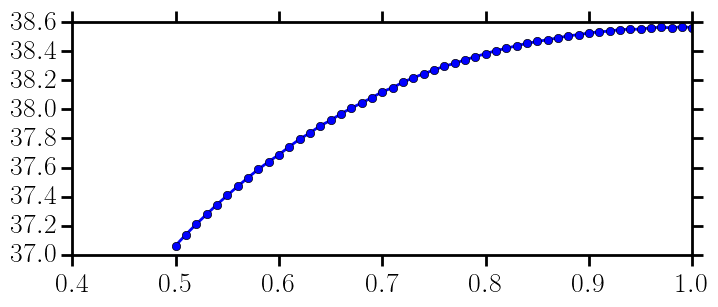

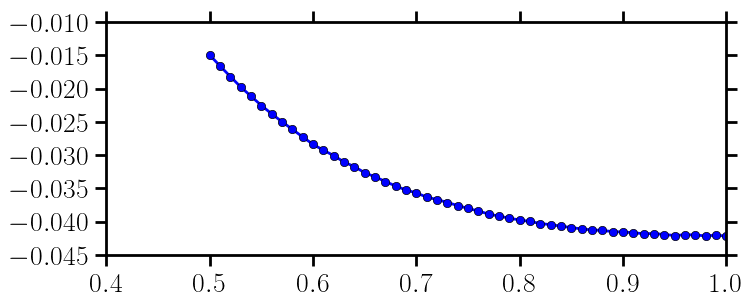

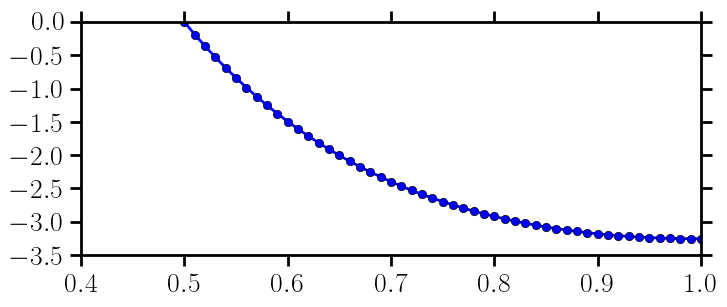

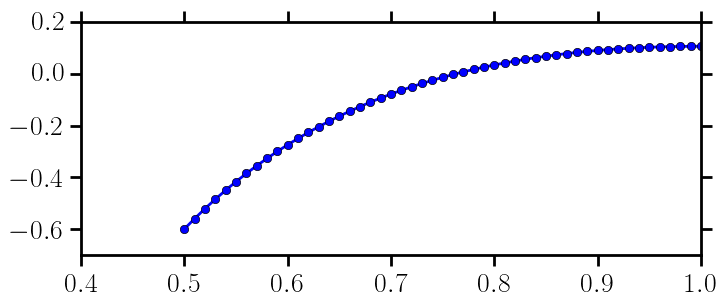

In [439]:
f = 0.01
print f, mf_to_f(f, 2.8)

amps = []
amp_err = []
for i in range(len(params)):
    h = hlist[i]
    q = params[i]
    amp = h.interpolate('amp')(f)
    ampf2 = taylorf2_amp(f, q/(1+q)**2)
    amps.append(amp)
    amp_err.append(amp/ampf2-1.0)
    

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(params, amps, 'o', ls='-', lw=2)

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(params, amp_err, 'o', ls='-', lw=2)
#axes.set_ylim(-0.50, 0.50)


phi_err = []
phis = []
for i in range(len(params)):
    h = hlist[i]
    q = params[i]
    phi = h.interpolate('phase')(f)
    phif2 = taylorf2_phase(f, 0.0, 0.0, q/(1+q)**2, lambda1, lambda2)
    phis.append(phi)
    phi_err.append(phi-phif2)

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(params, phis-phis[0], 'o', ls='-', lw=2)
#axes.plot(params, phis, 'o', ls='-', lw=2)

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(params, phi_err, 'o', ls='-', lw=2)

# Compare with TaylorF2 for single waveform

In [408]:
q, lambda1, lambda2 = 0.5, 5000, 5000
mf_lower, delta_tbym = 0.0009, 10.0
length = 1.0e6
mfon_end, mfoff_start, mfoff_end = 0.001, 0.015, 0.020
mftrunc_start = mfon_end
f_fitend = 0.002

# Original waveform
h = conditioned_waveform(q, lambda1, lambda2, 
                         mf_lower, delta_tbym, length, mfon_end, mfoff_start, mfoff_end, mftrunc_start,
                        approximant='TaylorT4')
h = match_taylorf2_at_beginning(h, q, lambda1, lambda2, f_fitend)
f2_phase = taylorf2_phase(h.x, 0.0, 0.0, q/(1+q)**2, lambda1, lambda2)

(-100, 20)

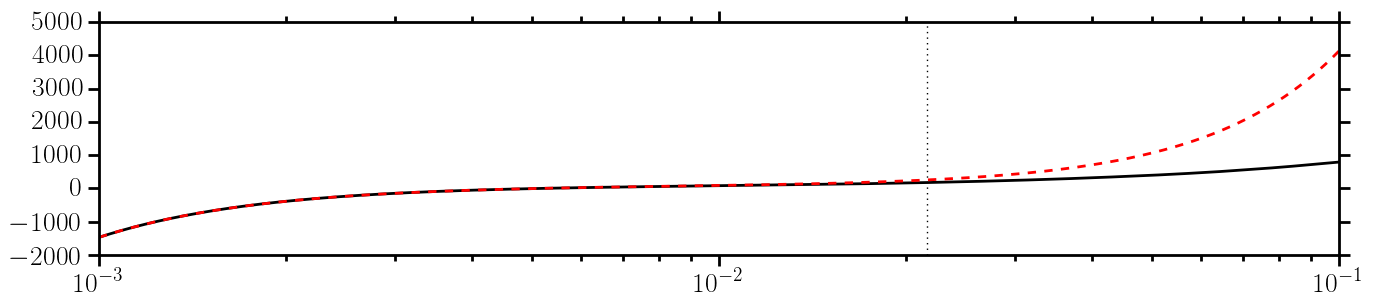

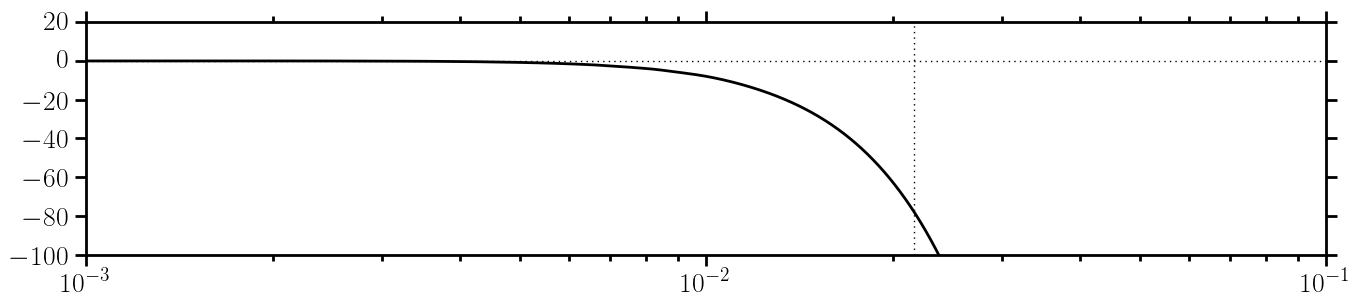

In [410]:
fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(h.x, h.phase, c='k', lw=2)
axes.plot(h.x, f2_phase, c='r', lw=2, ls='--')
axes.axvline(MF_ISCO, c='k', ls=':', lw=1)
axes.set_xscale('log')
#axes.set_yscale('symlog', linthreshy=1.0)


# Difference
diff = h.phase - f2_phase

fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(h.x, diff, c='k', lw=2)
axes.axhline(0.0, c='k', ls=':', lw=1)
axes.axvline(MF_ISCO, c='k', ls=':', lw=1)
axes.set_xscale('log')
axes.set_ylim(-100, 20)
#axes.minorticks_on()
#axes.set_yscale('symlog', linthreshy=1.0)

In [418]:
f = 0.022
lambda1, lambda2 = 0, 1000

q=0.5
print taylorf2_phase(f, 0.0, 0.0, q/(1+q)**2, lambda1, lambda2)-taylorf2_phase(f, 0.0, 0.0, q/(1+q)**2, 0, 0)

q=1.0
print taylorf2_phase(f, 0.0, 0.0, q/(1+q)**2, lambda1, lambda2)-taylorf2_phase(f, 0.0, 0.0, q/(1+q)**2, 0, 0)

4.22927053332
15.1122698984


In [412]:
f_to_mf(400, 2.8), MF_ISCO

(0.005516549948608805, 0.021658244478713225)

# Compare to pycbc TaylorF2

In [546]:
q, lambda1, lambda2 = 0.5, 5000, 100
mf_lower, mf_upper, delta_mf = 0.001, 0.05, 5.0e-7

# My TaylorF2 waveform
hf2 = taylorf2(0.0, 0.0, q/(1+q)**2, lambda1, lambda2, mf_lower, mf_upper, delta_mf)

# PYCBC TaylorF2 waveform
hpycbcf2 = dimensionless_fd_waveform(q, lambda1, lambda2, mf_lower, delta_mf, approximant='TaylorF2')

# TaylorT4
mf_lower, delta_tbym = 0.0009, 10.0
length = 1.0e6
mfon_end, mfoff_start, mfoff_end = 0.001, 0.015, 0.020
mftrunc_start = mfon_end
f_fitend = 0.002
ht4 = conditioned_waveform(q, lambda1, lambda2, 
                         mf_lower, delta_tbym, length, mfon_end, mfoff_start, mfoff_end, mftrunc_start,
                        approximant='TaylorT4')
ht4 = match_taylorf2_at_beginning(h, q, lambda1, lambda2, f_fitend)

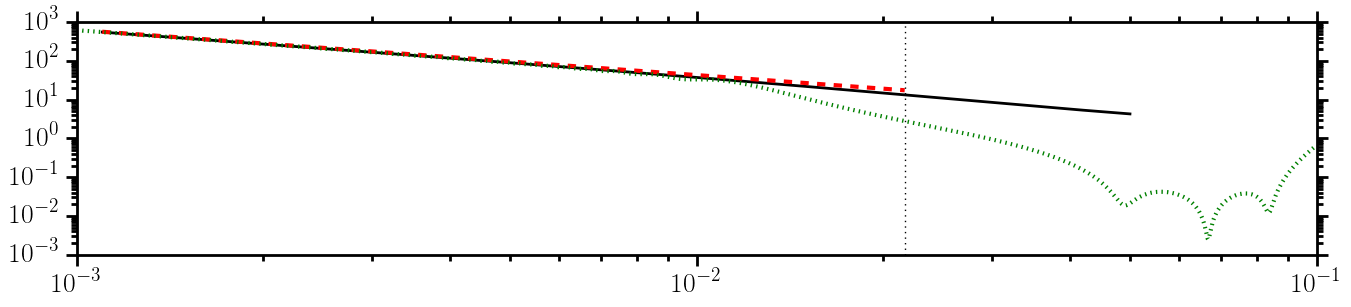

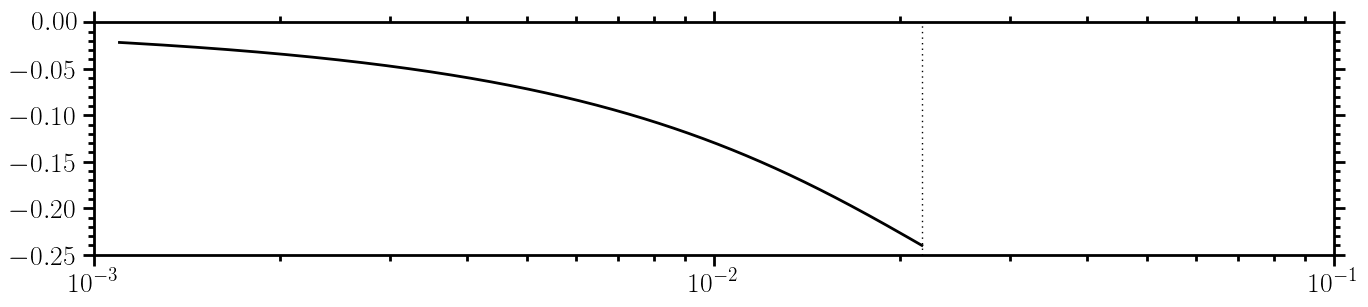

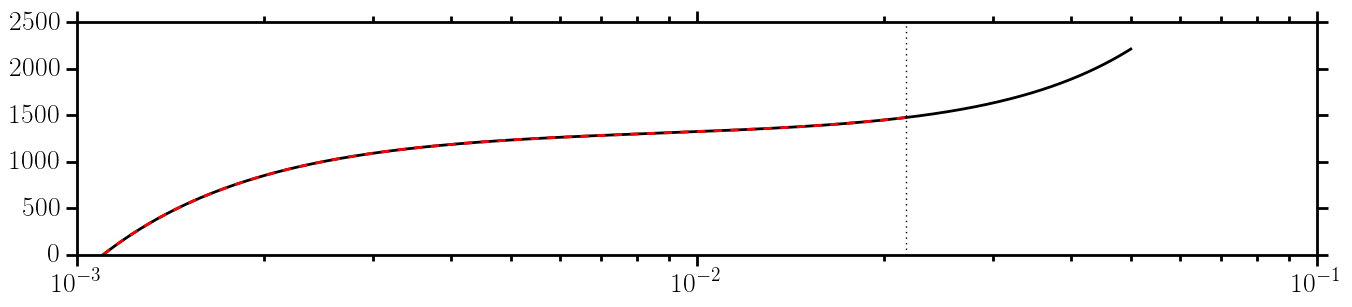

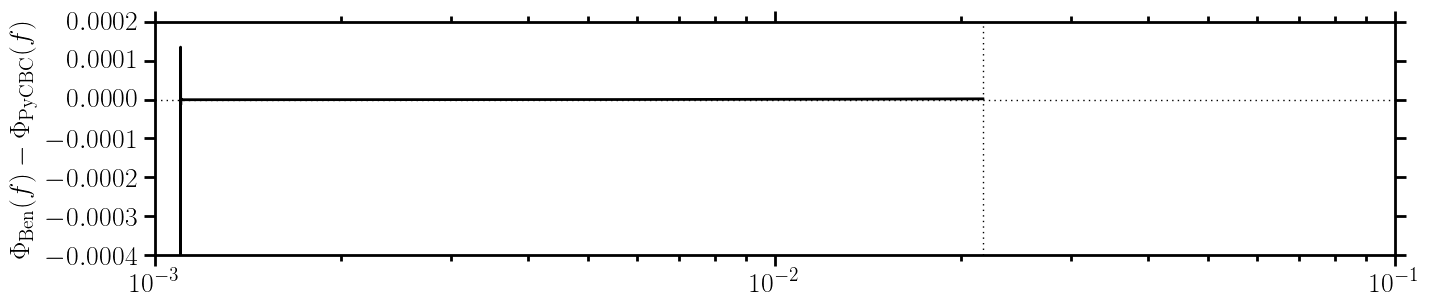

In [548]:
mf_start = 0.0011
hf2 = truncate_beginning(hf2, mf_start, remove_start_phase=True)
hpycbcf2 = truncate_beginning(hpycbcf2, mf_start, remove_start_phase=True)

# Phase difference
diff = subtract_waveform_phase(hf2, hpycbcf2, npoints=10000, spacing='log')

# Fractional amplitude difference
amp_ratio = waveform_amplitude_ratio(hf2, hpycbcf2, npoints=10000, spacing='log')


###### Amplitude ######
fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(hf2.x, hf2.amp, c='k', lw=2)
axes.plot(hpycbcf2.x, hpycbcf2.amp, c='r', lw=3, ls='--')
axes.plot(ht4.x, ht4.amp, c='g', lw=3, ls=':')
axes.axvline(MF_ISCO, c='k', ls=':', lw=1)
axes.set_xscale('log')
axes.set_yscale('log')

fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(amp_ratio.x, amp_ratio.amp-1.0, c='k', lw=2)
axes.axvline(MF_ISCO, c='k', ls=':', lw=1)
axes.set_xscale('log')
#axes.set_yscale('log')
axes.minorticks_on()

####### Phase #######

fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(hf2.x, hf2.phase, c='k', lw=2)
axes.plot(hpycbcf2.x, hpycbcf2.phase, c='r', lw=2, ls='--')
axes.axvline(MF_ISCO, c='k', ls=':', lw=1)
axes.set_xscale('log')

fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(diff.x, diff.phase, c='k', lw=2)
axes.axhline(0.0, c='k', ls=':', lw=1)
axes.axvline(MF_ISCO, c='k', ls=':', lw=1)
axes.set_xscale('log')
axes.set_ylabel(r'$\Phi_{\rm Ben}(f)-\Phi_{\rm PyCBC}(f)$')
#axes.minorticks_on()
#axes.set_yscale('symlog', linthreshy=1.0)

# Resampling functions

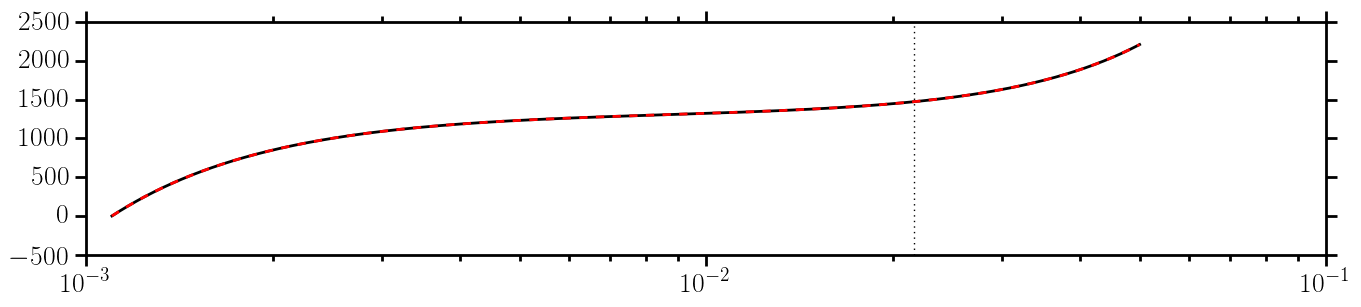

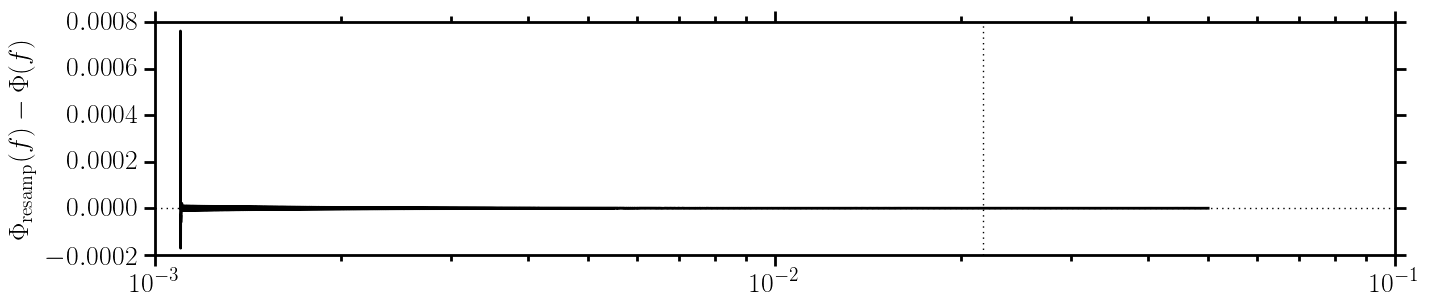

In [538]:
npoints = 1000
hf2resamp = hf2.copy()
resample_uniform(hf2resamp, npoints, spacing='log', order=3)


fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(hf2resamp.x, hf2resamp.phase, c='k', lw=2)
axes.plot(hf2.x, hf2.phase, c='r', lw=2, ls='--')
axes.axvline(MF_ISCO, c='k', ls=':', lw=1)
axes.set_xscale('log')

# Difference
diff = subtract_waveform_phase(hf2resamp, hf2, npoints=100000, spacing='log')

fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(diff.x, diff.phase, c='k', lw=2)
axes.axhline(0.0, c='k', ls=':', lw=1)
axes.axvline(MF_ISCO, c='k', ls=':', lw=1)
axes.set_xscale('log')
axes.set_ylabel(r'$\Phi_{\rm resamp}(f)-\Phi(f)$')
#axes.minorticks_on()
#axes.set_yscale('symlog', linthreshy=1.0)